In [36]:
from scipy.integrate import quad
import pandas as pd
import matplotlib.pyplot as plt
from numpy import sqrt, pi, exp

In [139]:
hist_data = pd.read_csv('ethprice.csv')
pd.options.display.max_rows = 20

%matplotlib inline

pd.set_option('display.mpl_style', 'default') 
plt.rcParams['figure.figsize'] = (15, 5)

In [109]:
#index 1002 represents last monday (30.4.)
hist_data['Date(UTC)'] = pd.to_datetime(hist_data['Date(UTC)'])
hist_data.head()

,Date(UTC),UnixTimeStamp,Value
0,2015-07-30,1438214400,0.0
1,2015-07-31,1438300800,0.0
2,2015-08-01,1438387200,0.0
3,2015-08-02,1438473600,0.0
4,2015-08-03,1438560000,0.0


In [136]:
#calculation of weekly variance (at the moment based only on Etherscan daily data)
#this can be improved by using bitfinex data of past trades
hist_data2 = hist_data
hist_data2['Difference'] = hist_data['Value']
for i in range(7, len(hist_data2)):
    hist_data2['Difference'][i] = hist_data2['Value'][i] - hist_data2['Value'][i-7]  

In [144]:
#hist_data2.tail(n=20)
hist_sd = hist_data2['Difference'].std()
hist_sd 

64.18342107316404

In [147]:
def call_premium(S_0, K, sd=hist_sd ):
    return quad(lambda x: (x/(sqrt(2*pi)*sd))*exp(-(x-S_0+K)**2/(2*sd**2)), 0, float("inf"))

In [148]:
call_premium(500,510)[0]

20.915636175631192

In [149]:
def put_premium(S_0, K, sd=hist_sd ):
    return quad(lambda x: (x/(sqrt(2*pi)*sd))*exp(-(x-(K-S_0))**2/(2*sd**2)), 0, float("inf"))

In [150]:
put_premium(500,490)[0]

20.915636175631192

In [151]:
#ratio = sold_calls/500
#K represents here the initial difference between S_0 and strike price
#mondays - nr. of past Mondays we are interested in
#ratios - list of ratio of sold calls and puts for each Monday
def simulation(margin, charge, ratios, mondays, K=10):
    assert len(ratios) == mondays
    df = pd.DataFrame()
    counter = 1
    for ratio in ratios:
        S_0 = hist_data.iloc[1002 - counter*7]["Value"]
        S_7 = hist_data.iloc[1002 - (counter-1)*7]["Value"]
        sold_call = ratio * 500 
        sold_put = (1 - ratio) * 500
        call_price = call_premium(S_0, S_0 + K)[0]*margin
        put_price = put_premium(S_0, S_0 - K)[0]*margin
        if ratio > 0.6:
            call_price += ratio*charge
        elif ratio < 0.4:
            put_price += (1 - ratio)*charge
        earnings = sold_call*call_price + sold_put*put_price
        payouts = sold_call*max(0, S_7 - (S_0 + K)) + sold_put*max((S_0 - K) - S_7, 0)
        result = earnings - payouts
        data = pd.DataFrame({"start date": hist_data.iloc[1002 - counter*7]["Date(UTC)"], 
                                "expiry date": hist_data.iloc[1002 - (counter-1)*7]["Date(UTC)"], "ratio": ratio,
                                                        "profit/loss": result, "start price": S_0, "expiry price": S_7,
                                                            "call price": call_price, "put price": put_price},
                                                                                                index=[counter-1])
        df = df.append(data)
        counter += 1
    cols = ['start date', 'expiry date', 'start price', 'expiry price', 'ratio', 'call price', 'put price', 'profit/loss']
    df = df[cols]
    #print(plt.bar(df['start date'], df['profit/loss']))
    print(df.plot(x='start date', y='profit/loss', kind='bar'))
    print(sum(df['profit/loss']))
    return df

Axes(0.125,0.125;0.775x0.755)
73069.3170538


,start date,expiry date,start price,expiry price,ratio,call price,put price,profit/loss
0,4/23/2018,4/30/2018,644.13,670.04,0.1,25.098763,70.098763,32003.881705
1,4/16/2018,4/23/2018,511.67,644.13,0.5,25.098763,25.098763,-18065.618295
2,4/9/2018,4/16/2018,399.02,511.67,0.4,25.098763,25.098763,-7980.618295
3,4/2/2018,4/9/2018,384.68,399.02,0.8,65.098763,25.098763,26813.381705
4,3/26/2018,4/2/2018,486.25,384.68,0.2,25.098763,65.098763,-8078.618295
5,3/19/2018,3/26/2018,555.55,486.25,0.6,25.098763,25.098763,689.381705
6,3/12/2018,3/19/2018,697.02,555.55,0.5,25.098763,25.098763,-20318.118295
7,3/5/2018,3/12/2018,849.42,697.02,1.0,75.098763,25.098763,37549.381705
8,2/26/2018,3/5/2018,867.62,849.42,0.0,25.098763,75.098763,33449.381705
9,2/19/2018,2/26/2018,939.79,867.62,0.5,25.098763,25.098763,-2993.118295


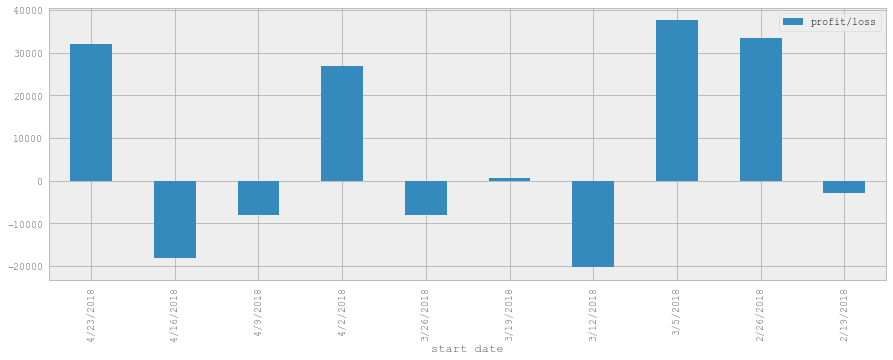

In [154]:
simulation(1.2, 50, [0.1, 0.5, 0.4, 0.8, 0.2, 0.6, 0.5, 1, 0, 0.5], 10)

## Questions:
- do we also include discount (besides charge) for options with smaller demand based on ratio of sold puts and calls?
- system of auction? I need more details to make simulation more realistic.
- best way to present results? design a simple user interface where one can play with inputs via sliders etc. or is a 'Jupyter notebook' in form similar to above enough? 
- is simulation based on past data enough? Also at the moment simulation is designed on  daily prices (and not on exact  Monday prices @15.00), does this suffice?
- my assumption was that demand of 500 ETH means that there are 500 options available at each auction. Is this correct?
- prices of call and put options are expressed here in USD, should they be in ETH (since ETH is the currency used on smart contracts)?